In [142]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

In [86]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind


def estimate_first_type_error(df_pilot_group, df_control_group, metric_name, alpha=0.05, n_iter=10000, seed=None):
    """Оцениваем ошибку первого рода.

    Бутстрепим выборки из пилотной и контрольной групп тех же размеров, считаем долю случаев с значимыми отличиями.
    
    df_pilot_group - pd.DataFrame, датафрейм с данными пилотной группы
    df_control_group - pd.DataFrame, датафрейм с данными контрольной группы
    metric_name - str, названия столбца с метрикой
    alpha - float, уровень значимости для статтеста
    n_iter - int, кол-во итераций бутстрапа
    seed - int or None, состояние генератора случайных чисел.

    return - float, ошибка первого рода
    """
    # YOUR_CODE_HERE
    def check_ttest(a, b, alpha=0.05):
        """Тест Стьюдента. Возвращает 1, если отличия значимы."""
        _, pvalue = ttest_ind(a, b)
        return int(pvalue < alpha)

    B = n_iter
    np.random.seed(seed=seed)
    a = df_pilot_group[metric_name].to_numpy()
    b = df_control_group[metric_name].to_numpy()
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))

    results = np.array([check_ttest(a_bootstrap[:,i], b_bootstrap[:,i], alpha=alpha) for i in range(n_iter)])
    #print(f"{np.sum(results)/results.size}, {np.mean(results)}")
    #return np.sum(results)/results.size
    return np.mean(results)

In [201]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind


def estimate_second_type_error(df_pilot_group, df_control_group, metric_name, effects, alpha=0.05, n_iter=10000, seed=None):
    """Оцениваем ошибки второго рода.

    Бутстрепим выборки из пилотной и контрольной групп тех же размеров, добавляем эффект к пилотной группе,
    считаем долю случаев без значимых отличий.
    
    df_pilot_group - pd.DataFrame, датафрейм с данными пилотной группы
    df_control_group - pd.DataFrame, датафрейм с данными контрольной группы
    metric_name - str, названия столбца с метрикой
    effects - List[float], список размеров эффектов ([1.03] - увеличение на 3%).
    alpha - float, уровень значимости для статтеста
    n_iter - int, кол-во итераций бутстрапа
    seed - int or None, состояние генератора случайных чисел

    return - dict, {размер_эффекта: ошибка_второго_рода}
    """
    # YOUR_CODE_HERE
    def check_ttest(a, b, alpha=0.05):
        """Тест Стьюдента. Возвращает 1, если отличия значимы."""
        _, pvalue = ttest_ind(a, b)
        return int(pvalue < alpha)

    B = n_iter
    np.random.seed(seed=seed)
    a = df_pilot_group[metric_name].to_numpy()
    b = df_control_group[metric_name].to_numpy()
    
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    
    result=dict()
    for effect in effects:
        a_bootstrap_effect=a_bootstrap*effect
        err_2 = np.array([check_ttest(a_bootstrap_effect[:,i], b_bootstrap[:,i], alpha=alpha) for i in range(n_iter)])
        
        #err_2 = np.array([check_ttest(a_bootstrap[:,i]*effect, b_bootstrap[:,i], alpha=alpha) for i in range(n_iter)])

        result[effect]=np.mean(abs(err_2-1))
        print(f"{effect=}, {result[effect]}")
    
    return result

# Ошибка второго рода

In [202]:
n=100
metric_name='value'
alpha=0.05
n_iter=1000
seed=10
effects = [1.0, 1.03, 1.1, 1.2, 1.5, 2, 3, 4]

samples = 1

df_pilot_group = pd.DataFrame(data=np.random.normal(1, 1, n), columns=[metric_name])
df_control_group=pd.DataFrame(data=np.random.normal(1, 1, n), columns=[metric_name])

%time rc = estimate_second_type_error(df_pilot_group, df_control_group, metric_name, effects, alpha=alpha, n_iter=n_iter, seed=seed)

rc

effect=1.0, 0.895
effect=1.03, 0.925
effect=1.1, 0.956
effect=1.2, 0.937
effect=1.5, 0.633
effect=2, 0.129
effect=3, 0.004
effect=4, 0.0
CPU times: user 12.7 s, sys: 36.8 ms, total: 12.7 s
Wall time: 12.8 s


{1.0: 0.895,
 1.03: 0.925,
 1.1: 0.956,
 1.2: 0.937,
 1.5: 0.633,
 2: 0.129,
 3: 0.004,
 4: 0.0}

In [175]:
CPU times: user 12.6 s, sys: 35.9 ms, total: 12.7 s
Wall time: 12.7 s

effect=1.0, 0.895
effect=1.03, 0.925
effect=1.1, 0.956
effect=1.2, 0.937
effect=1.5, 0.633
effect=2, 0.129
effect=3, 0.004
effect=4, 0.0
{1.0: 0.895,
 1.03: 0.925,
 1.1: 0.956,
 1.2: 0.937,
 1.5: 0.633,
 2: 0.129,
 3: 0.004,
 4: 0.0}

{1.03: 0.093}

In [164]:
a_bootstrap*1.03

array([[-1.42353753, -0.97248784, -0.97248784, -0.97248784, -0.97248784,
         0.18213215,  1.37870213, -0.97248784, -1.42353753, -0.97248784],
       [-0.97248784, -1.42353753,  1.37870213,  1.37870213,  0.16519153,
        -1.42353753,  0.16519153,  1.37870213,  0.18213215, -1.42353753],
       [ 0.16519153, -1.42353753, -0.97248784,  0.18213215, -0.97248784,
         0.16519153,  1.37870213,  1.37870213,  0.16519153, -0.97248784],
       [-1.42353753,  1.37870213, -0.97248784, -0.97248784,  0.16519153,
         0.16519153, -1.42353753,  0.16519153,  0.16519153,  0.18213215],
       [ 0.18213215,  0.16519153, -0.97248784,  1.37870213, -1.42353753,
         1.37870213,  0.16519153,  0.16519153, -1.42353753,  1.37870213]])

In [165]:
a_bootstrap[:,0]

array([-1.38207527, -0.94416295,  0.16038013, -1.38207527,  0.17682733])

In [166]:
a_bootstrap[:,0]*1.03

array([-1.42353753, -0.97248784,  0.16519153, -1.42353753,  0.18213215])

# Ошибка первого рода

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

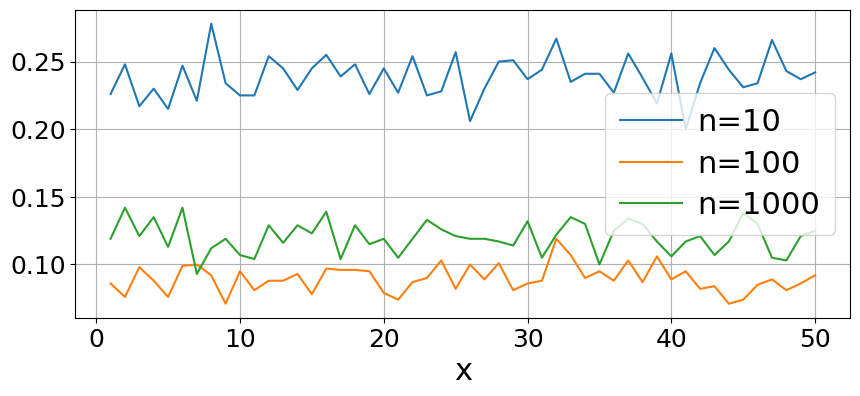

In [148]:
metric_name='value'
alpha=0.05
n_iter=1000
seed=None

samples=50

for n in [10,100,1000]:
    df_pilot_group = pd.DataFrame(data=np.random.normal(0, 1, n), columns=[metric_name])
    df_control_group=pd.DataFrame(data=np.random.normal(0, 1, n), columns=[metric_name])

    # Смотрим распределение ошибки
    error_1 = list()
    for i in tqdm(range(samples)):
        error_1.append(estimate_first_type_error(df_pilot_group, df_control_group, metric_name=metric_name, alpha=alpha, n_iter=n_iter, seed=seed))
    
    X = np.linspace(start=1,stop=len(error_1),num=len(error_1))
    Y = error_1
    plt.plot(X, Y, label=f"n={n}")
    
plt.legend()
plt.xlabel('x')
plt.grid()
plt.show()

In [56]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)



0.078

In [44]:
a_bootstrap[:,1]

array([ 0.72375714, -3.09448084,  0.72375714, -0.84299555,  2.4368604 ])

In [53]:

results

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [54]:
np.sum(results)/results.size

0.1